In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx

import matplotlib as mpl

mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

from typing import List
from collections import Counter
from scipy.integrate import solve_ivp

# The SIR model

We will focus on the SIR model, probably the most studied model in computational epidemics. In its simplest form, the SIR model can be defined as follows. A large population of $N$ individuals is divided into three classes:
+ **Susceptible** individuals (S): those who do not have the disease but can get it.
+ **Infected** individuals (I) : those who have the disease.
+ **Recovered** individuals (R): those who cannot get the disease anymore.

The basic dynamics of the model are simple as well:
1. Susceptible individuals might get infected if they are in contact with an infected individual. 
2. Infected individuals become recovered after some time. 

Notice that individuals can only go from *S* to *I* and from *I* to *R*. We will also assume that infective individuals have contacts with randomly chosen individuals of all states at an average rate $\beta$ per unit time, and recover and acquire immunity (or die) at an average rate $\gamma$ per unit time. 


### Fully mixed population
If we assume a very large population that is **fully mixed**, then the model can be descrived by a set of coupled nonlinear differential equations:  


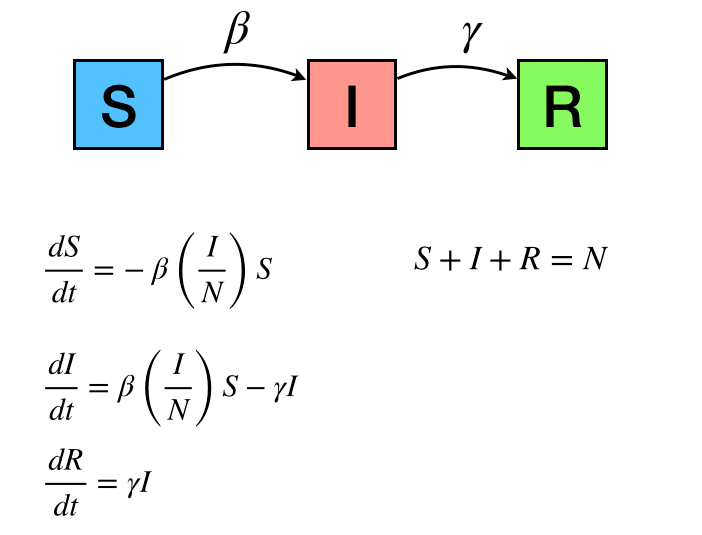

### Exercise 5.1
The `scipy.integrate` library has a function `solve_ip` that can be used to solve initial value problems for systems of ODES.
The documentation can be found [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html).

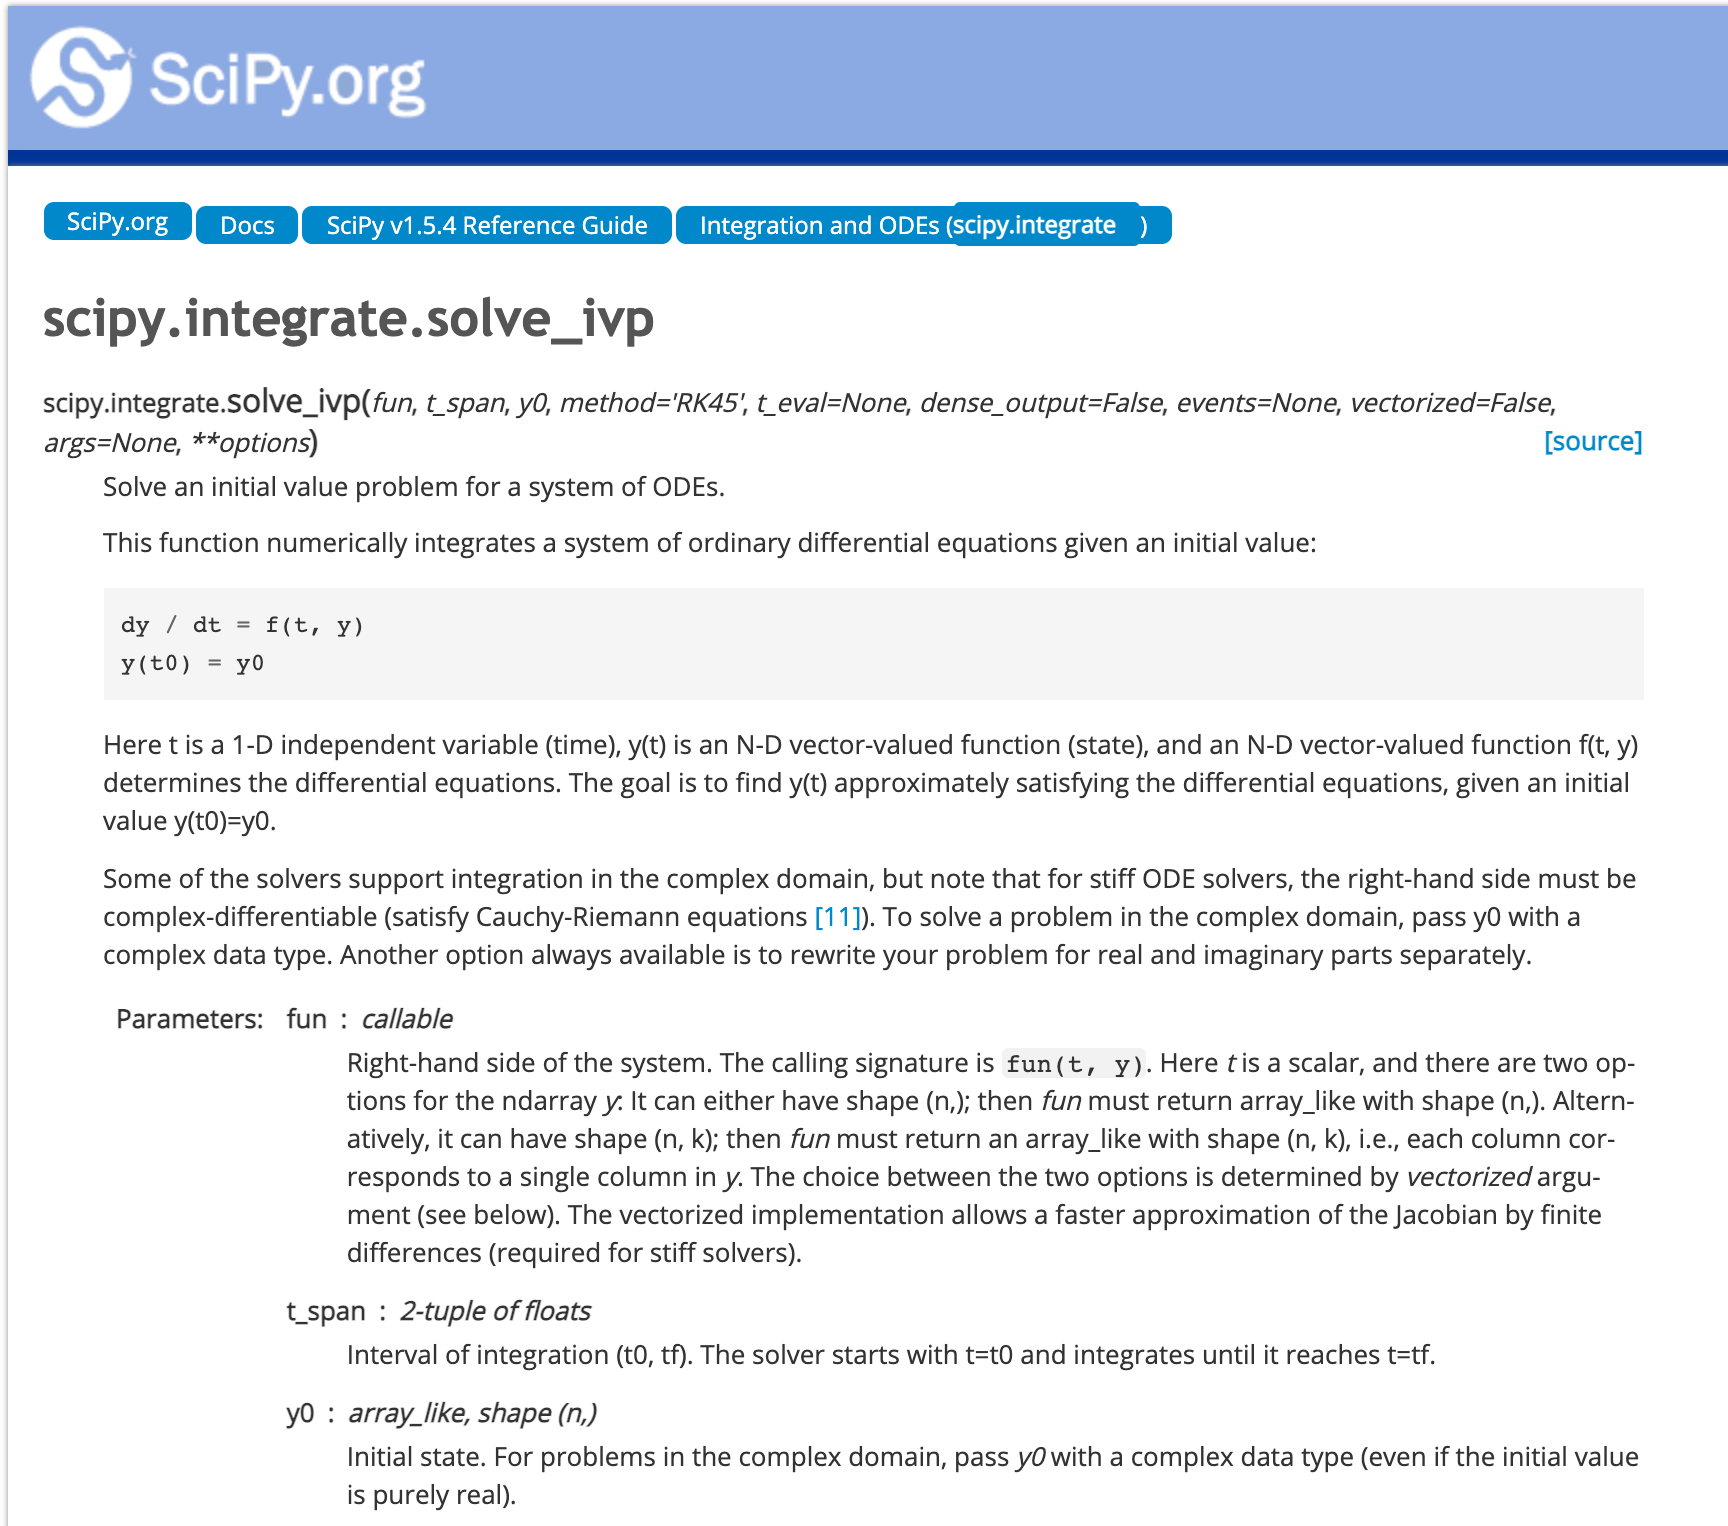


Read the documentation and try to understand how to use `solve_ivp`. The key bit is to notice that we have to write a **function** `f(t, y)`  whose first argument is the timepoint `t` and whose second argument `y` is a numpy array. In our case, y will have dimension 3. Do you see why?


The Initial Value Problem to be solved is then simply

```text
    dy / dt = f(t, y)
    y(t0) = y0
```


Write a function `ode_SIR` that represents the system of differential equations of a SIR model and follows the specification of `solve_ivp`.

In [2]:
def odes_SIR(t, y):
    """
    The main ODE equations of the SIR model
    """
    global beta,gamma
    S, I, R = y
    N = S + I + R
    f=np.array([
        - beta * (I/N)*S ,
        beta * (I/N)*S - gamma * I,
        gamma * I,        
    ])
    return f


### Exercise 5.2
Use `solve_ivp` and your `ode_SIR` function to study the behaviour of the SIR model for different values of the parameters, and describe your findings with a short paragraph.

In [3]:
# set parameters
beta=.2
gamma=.1
S=1_000_000
y0 = (S,1,0)
tmax = 365

In [4]:
# solve ODE
ode_result = solve_ivp(odes_SIR,t_span=(0,tmax),y0=y0)

In [5]:
# extract results
assert ode_result.success
t_range = ode_result.t
S, I, R = ode_result.y

Text(0, 0.5, 'population')

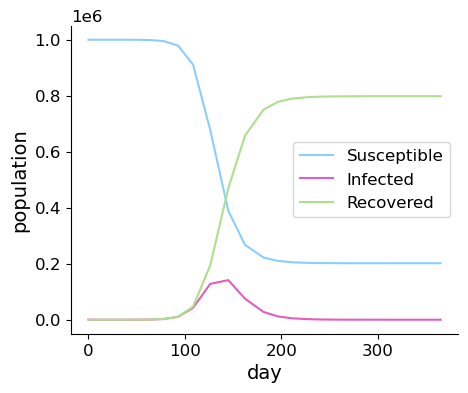

In [6]:
# OPTIONAL to get the same colors for S, I, R plots over all the notebook, we can define a dictionary of colors
SIR_colors = {
    "S": "#8aceff",
    "I": "#e35dbf",
    "R": "#ace08b"
}

# plot solution (S, I, R) on y axis, time on x-axis
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(t_range,
        S,
        label='Susceptible',
        color = SIR_colors['S']
)
ax.plot(t_range,
        I,
        label='Infected',
        color = SIR_colors['I']
)
ax.plot(t_range,
        R,
        label='Recovered',
        color = SIR_colors['R']
)
ax.legend()
ax.set_xlabel('day')
ax.set_ylabel('population')

For semplicity of exposure I considered the unity of time equal to 1 day.

The flow of the population is from Susceptible to Infected and then from infected to Recovered.

1. If gamma > beta the rate going from infected to recovered is much faster than from S to I, and so the disease never actually spread.

2. If beta >> gamma, the number of infected increases while the virus is spreaded, and all the population gets infected, due to the high number of infected caused my the slow rate of recover. Then the Infected number goest to 0 at a gamma rate as: $I = I_0 * e^{-\gamma t} $

3. If beta is not that big the equilibrium of the system is no more with all population Recovered. Part of the population never gets infected. The quilibrium ratio between S and R is related to the ratio between gamma and beta. A naive explanation is that, as the recovered increases it competes with the infected decreasing the spread rate


### SIR model on a network
The ODE approximation of the SIR model is not very realistic because it assumes a fully mixed population.
The fact that we do not interact randomly with one another, but rather have complex social structures, schools, commuting etc is what makes the whole thing much more difficult.

To explorer the importance of the **contact network** for the spread of a disease, we will implement a simple discrete-time SIR model that runs on an arbitrary network or graph. To do so, we will define a class `SIRonGraph` that holds together the **graph** where the SIR model runs and the **methods** (aka functions) that implement the SIR dynamics.

We will use the `networkx` module, a well-known python library to work with networks data. To check if you have it installed in your computer, run

In [7]:
import networkx as nx

If you get a `ModuleNotFoundError`, that means that you need to install it before continuing. In most cases, simply opening a terminal and running

```bash
> pip install networkx
```

should work. Additional installation instructions can be found [here](https://networkx.org/documentation/stable/install.html).

Networkx provides you the `Graph` type, that is, a kind of variable that represents a graph or network. Let us try it:

In [8]:
G = nx.Graph()

Networks have nodes and edges. Let us add some. Here we use letters to label the nodes, but integers would work as well.

In [9]:
G.add_nodes_from(["A", "B", "C", "D"])

In [10]:
G.add_edges_from([("A", "B"), ("B", "C"), ("C", "A"), ("C", "D")])

Now we want to have a look at our network. Networkx gives us some handy functions!

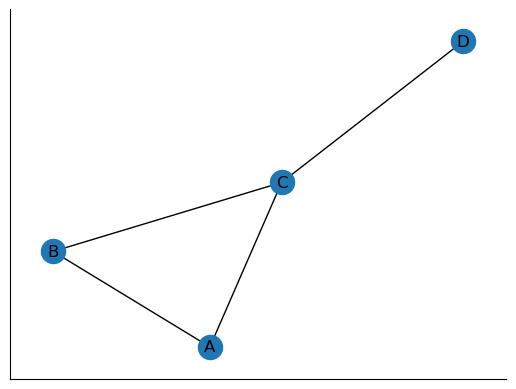

In [11]:
nx.draw_networkx(G)

Finally, networks can also hold some data on their nodes on edges. These are called **attributes** and are very useful. Let us create one:

In [12]:
initial_status = {
    "A": "S",
    "B": "S",
    "C": "I",
    "D": "S"
}

In [13]:
nx.set_node_attributes(G, initial_status, name="kind")

Now G carries the attribute *kind* with it. We can get the values of attributes of individual nodes easily:

In [14]:
G.nodes["C"]["kind"]

'I'

We can also modify the value of an attribute. Let us suppose node C infects node B. The we could do:

In [15]:
G.nodes["B"]["kind"] = "I"

If we need to get the attribute of all nodes, we can do it at once as follows:

In [16]:
current_status = nx.get_node_attributes(G, "kind")

In [17]:
current_status

{'A': 'S', 'B': 'I', 'C': 'I', 'D': 'S'}

### The SIR model as a python class

We will now create a class `SIRonGraph` to represent a SIR model on an arbitrary network. A class holds together data and functions (callled methods), and is exactly what we need in this case: a network and some functions that implement the SIR dynamics on it.

Classes can be a bit confusing at the beginning, but all you need to understand is that `self` means literary 'myself', that is, methods (functions) get as first argument the object they are acting on. This means that we can "store" a variable in one method and "retrieve" it in another! No need to pass it around!

Look at the following example code and play with it to make sure you understand how `self` works.

In [18]:
class Model:
    # this is a special method that gets called when you create an instance of your class
    def __init__(self, name):
        self.name = name
    
    def set_x(self, x):
        self.x = x
        
    def increment_x(self):
        self.x += 1

    def show_x(self):
        return self.x
    

In [19]:
model1 = Model(name="my first model")
model2 = Model(name="another model")

In [20]:
model1.set_x(3)
model2.set_x(-2)

In [21]:
model1.increment_x()

In [22]:
model1.show_x()

4

In [23]:
model2.show_x()

-2

We can also access information stored in our objects. Notice that our models had a name that was set at initialization.

In [24]:
model1.name

'my first model'

So, let us go back to our SIR model. The input to create a new SIR model on an arbitrary network is the following:

1. The graph onto which we want to run the SIR model.
2. A list of initially infected nodes.
3. The coefficient $\beta$
4. The coefficient $\gamma$

So, we create a class `SIRonGraph` that, when initialized, simply stores the input.

In [25]:
class SIRonGraph:
    def __init__(self, network: nx.Graph, initial_infected: List[int], beta: float, gamma: float) -> None:
        """
        Initialize a SIR model on a network. 
        """
        # store parameters
        self.beta = beta
        self.gamma = gamma
        self.network = network

Let us try it. First we need to create a graph! Networkx has some functions to generate standard graphs. We could start with a lattice graph, for instance.

In [26]:
# 2 rows, 3 columns
G = nx.hexagonal_lattice_graph(2, 3)

In [27]:
print(G)

Graph with 22 nodes and 27 edges


Notice that nodes are labelled with a tuple of integers `(col, row)` and that `G` comes with a nice `pos` node attribute, which we can use to nicely plot the network.

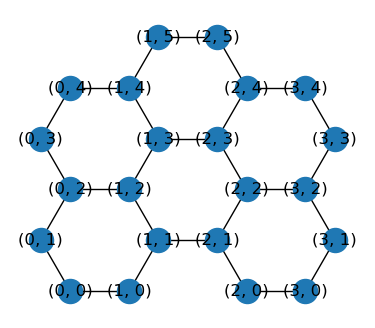

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.set_aspect(1)
ax.set_axis_off()

pos = nx.get_node_attributes(G, 'pos')
nx.draw_networkx(G, pos=pos)

Now we can create our first model

In [29]:
model = SIRonGraph(network=G, beta=0.3, gamma=0.1, initial_infected=[(1, 3)])

Notice that you can retrieve all the information that is stored in `self`. 

In [30]:
model.network

Notice that `model.network` is not a copy of `G`: it is exactly the same object, point to the same memory address!

In [31]:
G

In [32]:
model.beta

0.3

In [33]:
model.gamma

0.1

### Exercise 5.3
Our model should do a few more things at initialization:
1. Checking that $\beta$ and $\gamma$ have sensible values.
2. Making sure that all elements in input list of inital infected are really nodes of the network.
2. Creating a node attribute called "kind" with value "S" for all nodes except for those in the list of `inital_infected`

Extend the SIRonGraph code below and implement points 1 and 2 in the ``__init__`` method.

In [34]:
class SIRonGraph:
    def __init__(self, network: nx.Graph, initial_infected: List[int], beta: float, gamma: float) -> None:
        """Initialize a SIR model on a network. 
        All nodes are set to S except those passed in the initial_infected list.
        """
        # make sure node in initial_infected list are really nodes of the network.
        assert all([infected_node in network for infected_node in initial_infected])
            
        # make sure params make sense 
        assert beta >= 0 and beta <=1
        assert gamma >= 0 and gamma <=1
        
        
        # set initial status of nodes as node att
        initial_status = {node:'I' if node in initial_infected else 'S' for node in network.nodes}
        nx.set_node_attributes(network, initial_status, name="kind")
       
        
        # store parameters
        self.network = network
        self.beta = beta
        self.gamma = gamma
    

In [35]:
model = SIRonGraph(network=G, beta=0.3, gamma=0.1, initial_infected=[(1, 3)])

### Exercise 5.4
1. Create a function to visualize a hexagonal lattice model, with nodes colored by type. Your function should take as input the model instance (object of kind SIRonGraph) and display the network, coloring S, I and R nodes with different colors.
2. Show that your function works for a few examples with different input graph sizes and different sets of initially infected nodes.

**Tip**: look into the networkx documentation! It is [here](https://networkx.org/documentation/stable/reference/drawing.html).

In [36]:
def show_hex_model(model,with_labels = True, ax=None):
    # creates a figure if no axis was passed
    ax_was_none = ax is None
    if ax_was_none:
        # create a figure
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        ax.set_aspect(1)
        ax.set_axis_off()
        
    network = model.network
    # get the positions and kind of nodes
    pos = nx.get_node_attributes(network, 'pos')
    kinds = nx.get_node_attributes(network, "kind")

    # prepare a list of colors for the nodes using the kinds dict
    SIR_colors = {
        "S": "#8aceff",
        "I": "#e35dbf",
        "R": "#ace08b"
    }
    node_color = [SIR_colors[kinds[node]] for node in network]
    # draw the network
    nx.draw_networkx(network, pos=pos,node_color=node_color,ax=ax,with_labels=with_labels)
    # returns the new figure if it was created here
    if ax_was_none:
        return fig, ax

In [37]:
networks = [nx.hexagonal_lattice_graph(4, 3),nx.hexagonal_lattice_graph(7, 14)]
initial_infected_list = [[(1,2),(3,3),(3,4)],[(0,0),(0,1),(2,2)],[(3,3),(3,2)]]

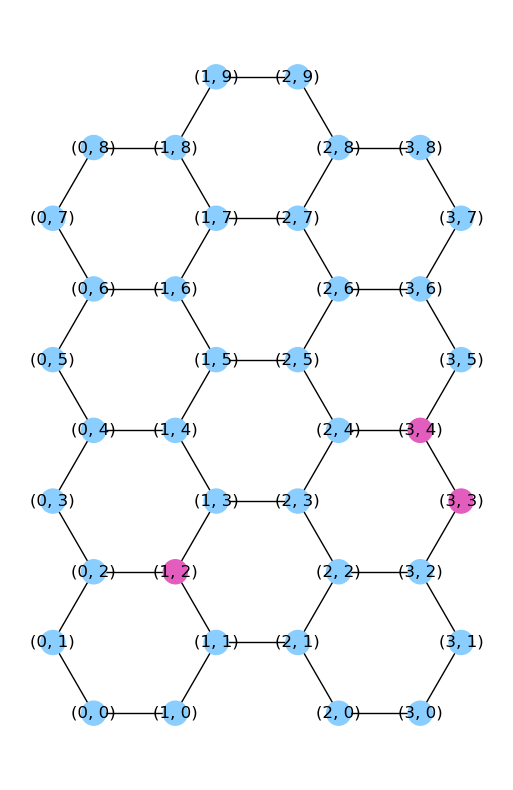

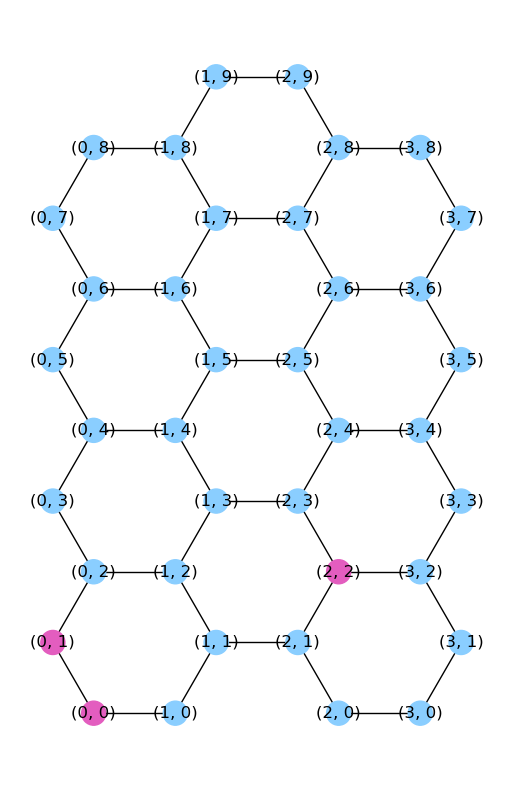

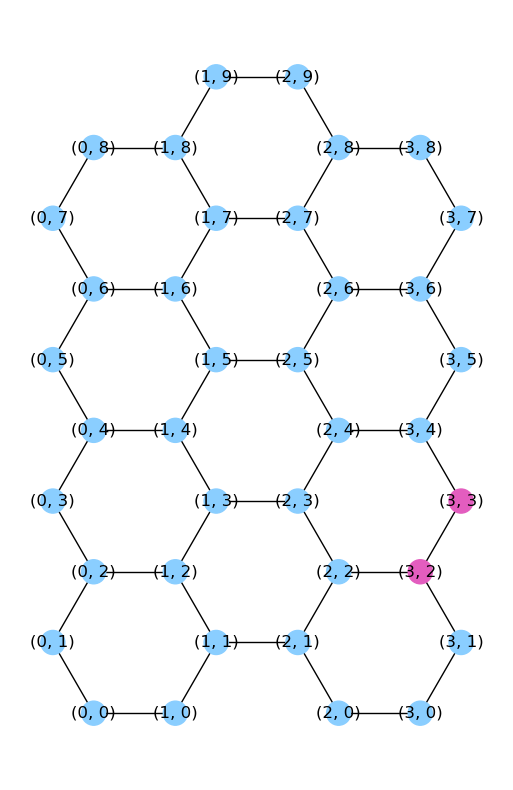

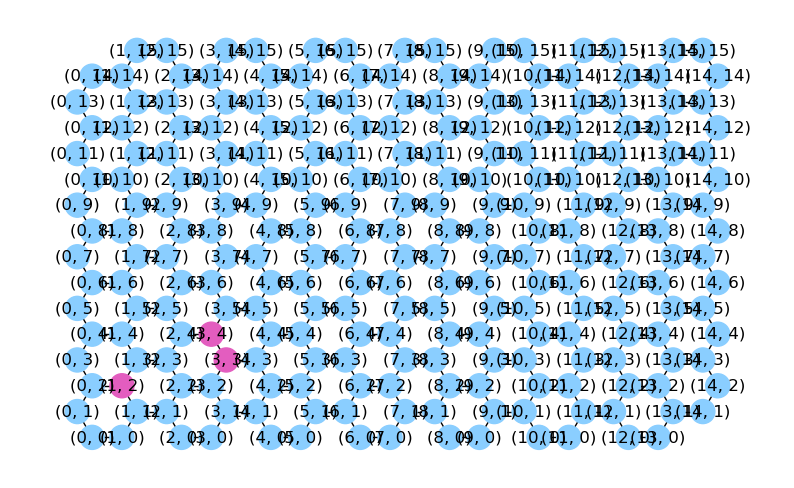

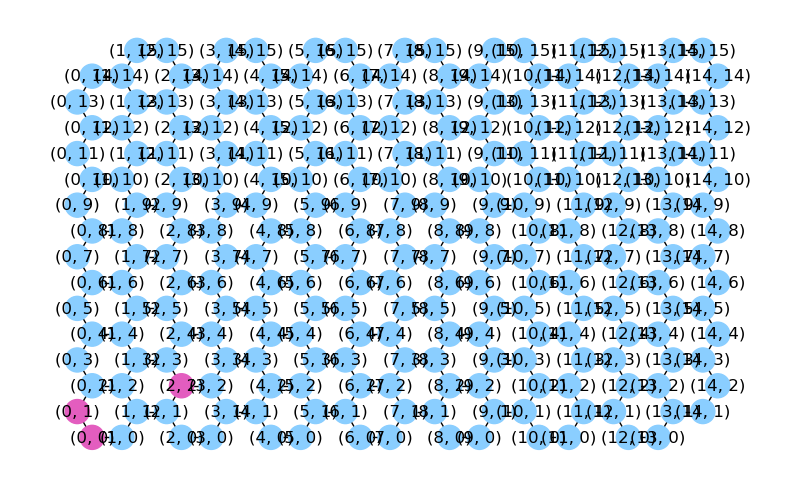

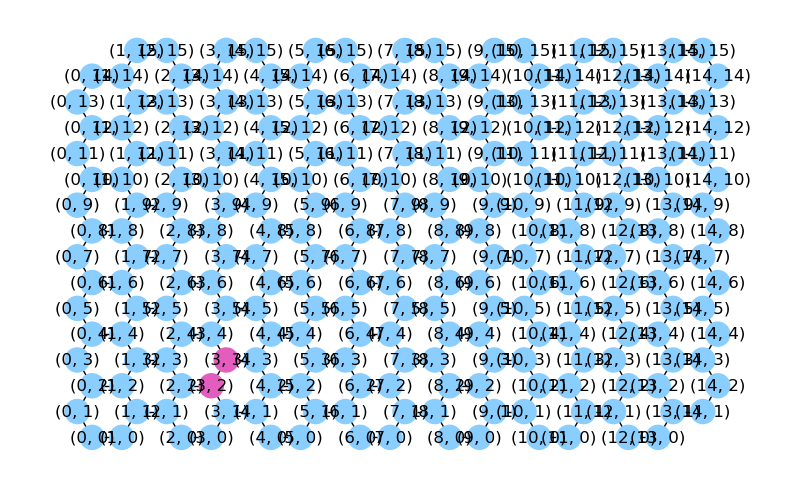

In [38]:
for network in networks:
    for initial_infected in initial_infected_list:
        show_hex_model(SIRonGraph(network, beta=0.3, gamma=0.1, initial_infected=initial_infected))

### SIR dynamics as class methods
Now we want to be able to run the SIR dynamics on our `SIRonGraph` objects. To simplify things, we  consider **discrete time** simulation, so that at each time-step:
+ Infected individuals have a chance to recover, and they do so with probability $\gamma$.
+ Susceptible individuals can be infected by any of the infected individuals to which they are connected. This happens with probability $\beta$ for each S-I edge.

### Exercise 5.5
Implement the dynamics of the SIR model as methods of your `SIRonGraph` class. You might want to implement two methods separately, as follows:

+ `_step(self)`: this method implements one single time-step, as descrived above.
+ `run(self, num_timesteps: int)`: this method (for now) simply calls `_step` repeatedly.

You will see, in a while, that it is useful to organize things as we are doing.

In [39]:
#progress bar for debugging
def progress_bar(percent=0, width=30,additional_str = None):
    percent = int(percent)
    left = width * percent // 100
    right = width - left
    if additional_str:
        print('\r[', '#' * left, ' ' * right, ']',
          f' {percent:.0f}% \t',additional_str,
          sep='', end='', flush=True)
    else:
        print('\r[', '#' * left, ' ' * right, ']',
              f' {percent:.0f}%',
              sep='', end='', flush=True)

In [40]:
class SIRonGraph:
    def __init__(self, network: nx.Graph, initial_infected: List[int], beta: float, gamma: float) -> None:
        """Initialize a SIR model on a network. 
        All nodes are set to S except those passed in the initial_infected list.
        """
        # you already wrote the code for init, just copy it here!
        assert all([infected_node in network for infected_node in initial_infected])
            
        # make sure params make sense 
        assert beta >= 0 and beta <=1
        assert gamma >= 0 and gamma <=1
        
        
        # set initial status of nodes as node att
        initial_status = {node:'I' if node in initial_infected else 'S' for node in network.nodes}
        nx.set_node_attributes(network, initial_status, name="kind")
       
        
        # store parameters
        self.network = network
        self.beta = beta
        self.gamma = gamma
    
    def run(self, num_timesteps: int):
        """Run SIR dynamics for num_timsteps steps"""
        for time in range(num_timesteps):
            self._step()
            #progress_bar
            progress_bar(percent = (time+1)/num_timesteps * 100)
            
            
        
    def _step(self):
        """Do one discrete timestep."""
        # recoveries
        # remember: I -> R with prob gamma
        network = self.network
        for node in network.nodes:
            #if the node kind is I throw a coin and change it to R
            if network.nodes[node]['kind'] == 'I':
                salvation_coin = np.random.random()
                if salvation_coin < self.gamma:
                    network.nodes[node]['kind'] = 'R'
            
            
        # infections
        # remember: S -> I with prob beta for each edge S-I (or I-S)
        for edge in network.edges:
            #first I save the two nodes of the edge
            edge_nodes = [node for node in edge]
            #for the sake of simplicity I use only the case S-I thus changing the order at the beginning of the two nodes
            
            kinds = [network.nodes[node]['kind'] for node in edge_nodes]
            if kinds == ['I','S']:
                edge_nodes.reverse()
                kinds.reverse()
            
            #if ['S','I'] with probability beta the first node get infected
            if kinds == ['S','I']:
                death_coin = np.random.random()
                if death_coin < beta:
                    network.nodes[edge_nodes[0]]['kind'] = 'I'
            
            
            

### Exercise 5.6
Use your visualization function to show the evolution of a SIR model running in a hex lattice. You should decide the system size, number of timesteps and other parameterrs wisely to show that your code works properly.

In [41]:
G = nx.hexagonal_lattice_graph(10, 10)

[##############################] 100%

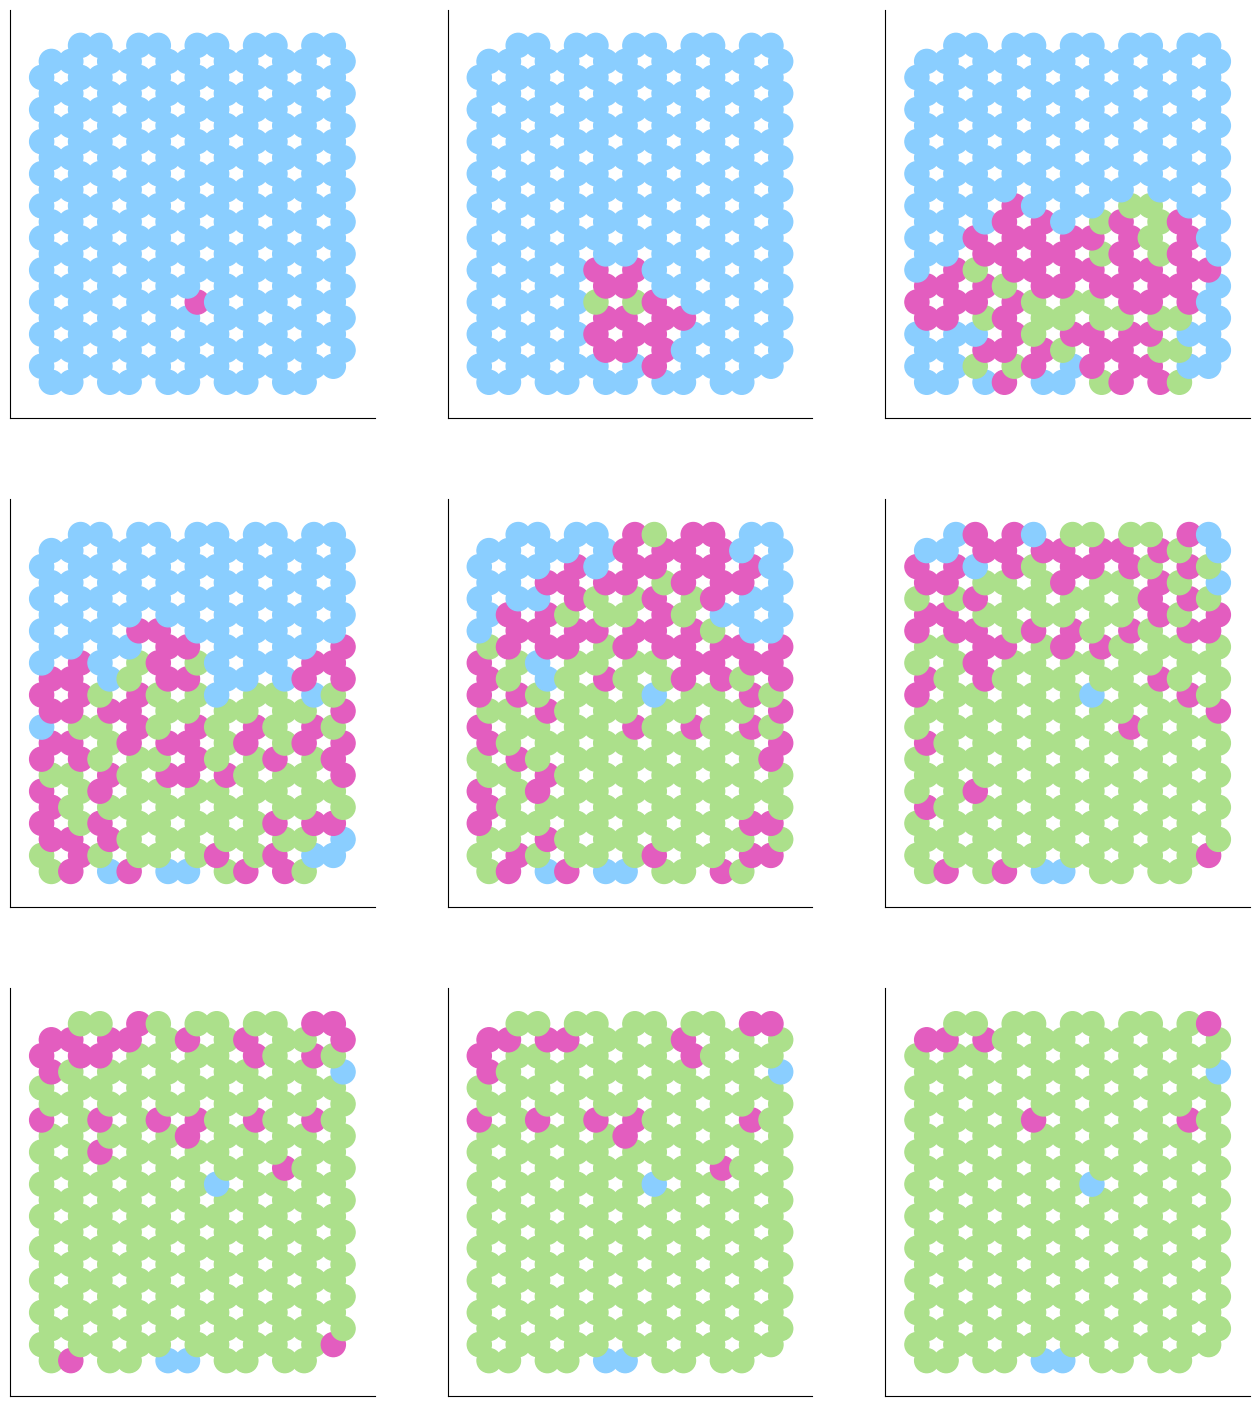

In [42]:
model = SIRonGraph(network=G, initial_infected=[(5, 5)], beta=0.3, gamma=0.05)


fig, axx = plt.subplots(3, 3, figsize=(16, 18))
axx = axx.reshape(-1)

for ax in axx:
    ### plot model status on axis ax
    show_hex_model(model,ax=ax,with_labels=False)
    
    ### run the model for some timesteps
    model.run(num_timesteps=15)

### Storing SIR evolution as a class attribute
Now our class can run the SIR dynamics, but it doesn't "remember" the whole evolution of the simulation: only the final state is available. One way of storing some quantities of interest during the simulation is as follows:

1. Create an empty list at initialization.
```python
class SIRonGraph:
     def __init__(self, G: nx.Graph, initial_infected: List[int], beta: float, gamma: float) -> None:
         ...
         # empty list, we will add info durring the simulation
         self.history = []
         ...
```

2. Create a _log() method that, when called, computes the information we want to store and adds it to the self.history list.

```python
   def _log(self):
        # do computations
        var1 = ...
        var2 = ...
        ...
        
        # create a block of info as list
        info = [var1, var2, ...]
        # or as a dict
        info = {
            "var1": var1,
            "var2": var2,
            ...
        }
        # or using any other scheme you like
        info = ...
        
        # add the info block to the history log
        self.history.append(info)
```

3. Call the ._log() method every time you want to store the variables of interest. That could be at every timestep or once in a while only. 
It is also wise to call `._log()` once at initialization, to store the initial status. 
```python
   def __init__(self, ...):
         ...
         self._log()
        
   def run(self, num_timesteps: int):
         """Run the SIR dynamics for some time."""
         ...
         for _ in range(num_timesteps):
              self._step()
              self._log()
         ...
```

### Exercise 5.7
1. Modify your SIRonGraph class so that it stores the number of **S**, **I** and **R** individuals at each timestep.
2. Simulate the SIR model in a network of your choice, and plot the evolution of the system (S, I, R) over time. Try to choose the parameters wisely, so that a typical epidemic wave can be seen.

In [43]:
class SIRonGraph:
    def __init__(self, network: nx.Graph, initial_infected: List[int], beta: float, gamma: float) -> None:
        """Initialize a SIR model on a network. 
        All nodes are set to S except those passed in the initial_infected list.
        """
        # you already wrote the code for init, just copy it here!
        assert all([infected_node in network for infected_node in initial_infected])
            
        # make sure params make sense 
        assert beta >= 0 and beta <=1
        assert gamma >= 0 and gamma <=1
        
        
        # set initial status of nodes as node att
        initial_status = {node:'I' if node in initial_infected else 'S' for node in network.nodes}
        nx.set_node_attributes(network, initial_status, name="kind")
       
        
        # store parameters
        self.network = network
        self.beta = beta
        self.gamma = gamma      
    
        # create empty list to store history        
        self.history = []
        # store info of initial condition
        self._log()
        
        
    def run(self, num_timesteps: int):
        """Run SIR dynamics for num_timsteps steps"""
        for time in range(num_timesteps):
            self._step()
            self._log()
            #progress_bar
            progress_bar(percent = (time+1)/num_timesteps * 100)
            
            
        
    def _step(self):
        """Do one discrete timestep."""
        # recoveries
        # remember: I -> R with prob gamma
        network = self.network
        for node in network.nodes:
            #if the node kind is I throw a coin and change it to R
            if network.nodes[node]['kind'] == 'I':
                salvation_coin = np.random.random()
                if salvation_coin < self.gamma:
                    network.nodes[node]['kind'] = 'R'
            
            
        # infections
        # remember: S -> I with prob beta for each edge S-I (or I-S)
        for edge in network.edges:
            #first I save the two nodes of the edge
            edge_nodes = [node for node in edge]
            #for the sake of simplicity I use only the case S-I thus changing the order at the beginning of the two nodes
            
            kinds = [network.nodes[node]['kind'] for node in edge_nodes]
            if kinds == ['I','S']:
                edge_nodes.reverse()
                kinds.reverse()
            
            #if ['S','I'] with probability beta the first node get infected
            if kinds == ['S','I']:
                death_coin = np.random.random()
                if death_coin < self.beta:
                    network.nodes[edge_nodes[0]]['kind'] = 'I'
           
        
    def _log(self):
        #I store a dictionary counting the values (so it si a more human readable log)sns
        #example info: Counter({'S': 236, 'I': 2})
        info = Counter(nx.get_node_attributes(self.network, 'kind').values())
        self.history.append(info)
                

In [44]:
# create the model
model = SIRonGraph(
    network=nx.hexagonal_lattice_graph(30, 20),
    initial_infected=[(10, 10), (2, 2), (2, 5)],
    beta=0.3,
    gamma=0.03
)
# run the model for some time
n_steps = 365
model.run(num_timesteps=n_steps)

[##############################] 100%

In [45]:
# extract evolution of S, I, R from model.history
S=np.zeros(len(model.history))
I=np.zeros(len(model.history))
R=np.zeros(len(model.history))
for i,history_step in enumerate(model.history):
    S[i] = history_step['S']
    I[i] = history_step['I']
    R[i] = history_step['R']


Text(0, 0.5, 'population')

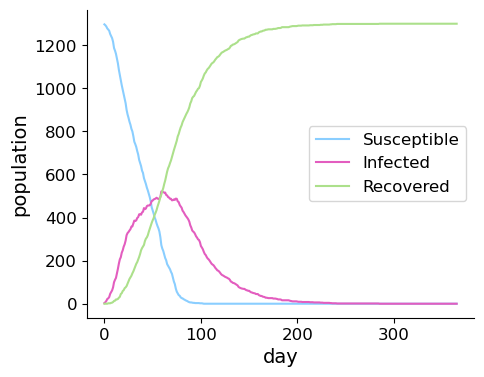

In [46]:
# plot S,I,R vs time
# OPTIONAL to get the same colors for S, I, R plots over all the notebook, we can define a dictionary of colors
SIR_colors = {
    "S": "#8aceff",
    "I": "#e35dbf",
    "R": "#ace08b"
}
t_range = range(n_steps +1)
# plot solution (S, I, R) on y axis, time on x-axis
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(t_range,
        S,
        label='Susceptible',
        color = SIR_colors['S']
)
ax.plot(t_range,
        I,
        label='Infected',
        color = SIR_colors['I']
)
ax.plot(t_range,
        R,
        label='Recovered',
        color = SIR_colors['R']
)
ax.legend()
ax.set_xlabel('day')
ax.set_ylabel('population')

### Exercise 5.8
##### Which kind of network could give results equivalent to the ODE solution of the first part of the notebook? Explain why.

The complete graph, in which anyone meets everyone every day.
In such a case there is no effect conncected to the topology, but every node is equal to any other.

Indeed there will be problems in the value of Beta, as it has two slihghty different meanings in the two approaches.
In the first one is the correalation rate between the Infected and the Suscetptible, in the second one simply the probability that the contact between an Infected and a Susceptible ends in the spreading of the virus

In the first case any susceptible has $P=\beta * \frac{I}{N}$ to get infected,
In the second one $P = 1 - (1-\beta)^I$. If $\beta$ is small it is $P \approx \beta I$,
We then need to adjust our Beta by a N factor


### Exercise 5.9
Compare the ODE solution with simulation results on the appropiate network. Do you see differences? If so, explain why.
Remember to properly add labels and legends to all your plots!

In [47]:
# set parameters
beta=.1
gamma=.03
population=200
S = population - 1
y0 = (S,4,0)
tmax = 365

In [48]:
# define your model
model = SIRonGraph(
    network=nx.complete_graph(population),
    beta=beta/population,
    gamma=gamma,
    initial_infected=[1,2,3,4]
)

In [49]:
model.beta

0.0005

In [50]:
# run the model, extrarct results
# run the model for some time
model.run(num_timesteps=tmax)


[##############################] 100%

In [51]:
# extract evolution of S, I, R from model.history
S_graph=np.zeros(len(model.history))
I_graph=np.zeros(len(model.history))
R_graph=np.zeros(len(model.history))
for i,history_step in enumerate(model.history):
    S_graph[i] = history_step['S']
    I_graph[i] = history_step['I']
    R_graph[i] = history_step['R']


### ODE

In [52]:
# solve ODE
ode_result = solve_ivp(odes_SIR,t_span=(0,tmax +1),y0=y0)

In [53]:
# extract results
assert ode_result.success
t_range = ode_result.t
S_ode, I_ode, R_ode = ode_result.y

In [54]:
# optional: maybe more than one simulation and then average?

Text(0.5, 1.0, 'ODE results')

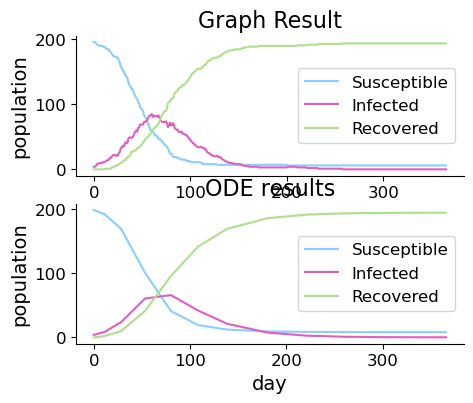

In [55]:
# plot results togetherr with old ODE results
# plot S,I,R vs time
# OPTIONAL to get the same colors for S, I, R plots over all the notebook, we can define a dictionary of colors
SIR_colors = {
    "S": "#8aceff",
    "I": "#e35dbf",
    "R": "#ace08b"
}
t_range = range(n_steps +1)
# plot solution (S, I, R) on y axis, time on x-axis
fig, axx = plt.subplots(2, 1, figsize=(5, 4))
axx = axx.reshape(-1)

ax = axx[0]
ax.plot(t_range,
        S_graph,
        label='Susceptible',
        color = SIR_colors['S']
)
ax.plot(t_range,
        I_graph,
        label='Infected',
        color = SIR_colors['I']
)
ax.plot(t_range,
        R_graph,
        label='Recovered',
        color = SIR_colors['R']
)
ax.legend()
ax.set_xlabel('day')
ax.set_ylabel('population')
ax.set_title('Graph Result')



t_range = ode_result.t
ax = axx[1]
ax.plot(t_range,
        S_ode,
        label='Susceptible',
        color = SIR_colors['S']
)
ax.plot(t_range,
        I_ode,
        label='Infected',
        color = SIR_colors['I']
)
ax.plot(t_range,
        R_ode,
        label='Recovered',
        color = SIR_colors['R']
)
ax.legend()
ax.set_xlabel('day')
ax.set_ylabel('population')
ax.set_title('ODE results')

The difference are not so huge

## The spread of epidemic disease on networks
We will now follow some of the derivations in 

*Spread of epidemic disease on networks.*  
Newman, M.E.J. (2002).  
Phys. Rev. E Stat. Nonlin. Soft Matter Phys. 66, 016128.  

You can get the preprint version of the paper, which is almost equal to the published verison, here:  
[https://arxiv.org/abs/cond-mat/0205009](https://arxiv.org/abs/cond-mat/0205009)  

Remember that the *transmissibility* $T$ is the average probability that a victim will infect each of their contacts.
In the paper, Newmann computes it as (Eq 6)
$$
T =  1 - \int_0^\infty dr \sum_{\tau=0}^{\infty} P(r) P(\tau) (1-r)^\tau
$$

### Exercise 5.10
Read the first part of the paper. Under which assumptions is the Eq. 6 valid? What is the meaning of $r$ and $\tau$ in the manuscript? Can you relate $P(r)$ and $P(\tau)$ to our coefficients $\beta$ and $\gamma$?

##### Under which assumptions is the Eq. 6 valid?
Eq.6 is valid under the assumption that both $r$ and $\tau$ are iid (Independent and identically distributed) random variables. And so the average of T is the average over the $r$ and $\tau$ probability distributions
##### What is the meaning of 𝑟 and 𝜏 in the manuscript?
$r$ is the rate of disease-causing. It is the probability that in the unity of time an Infected spread the disease to a Susceptible

$\tau$ is the time it takes for an Infected to get Recovered

##### Can you relate 𝑃(𝑟) and 𝑃(𝜏) to our coefficients 𝛽 and 𝛾?

$r$ is exactly our $\beta$ namely the probability in the unity of time that a Susceptible in contact with an Infected gets the disease.
Therefore 
$$ P(r) = \delta(r-\beta)$$

$\tau$ is the time an Infected stays so, while $\gamma$ is the the probability in the unity of time that an Infected gets Recovered.
$$
P(\tau) = P_{S->I}(\tau) = (1-\gamma)^\tau * \gamma
$$

### Exercise 5.11
Compute the transmissiblity $T$ of our discrete-time SIR model in terms of $\beta$ and $\gamma$ using Newman's calculation (but bear in mind that this result is valid only under the assumptions of the paper).

$$
T = 1 - \frac{1}{(1-\beta)+\frac{\beta}{\gamma}}
$$

# Inserire calcoli presenti su tablet

### Exercise 5.12
Add a method to your class to compute the transmissibility $T$.

In [56]:
class SIRonGraph:
    def __init__(self, network: nx.Graph, initial_infected: List[int], beta: float, gamma: float) -> None:
        """Initialize a SIR model on a network. 
        All nodes are set to S except those passed in the initial_infected list.
        """
        # you already wrote the code for init, just copy it here!
        assert all([infected_node in network for infected_node in initial_infected])
            
        # make sure params make sense 
        assert beta >= 0 and beta <=1
        assert gamma >= 0 and gamma <=1
        
        
        # set initial status of nodes as node att
        initial_status = {node:'I' if node in initial_infected else 'S' for node in network.nodes}
        nx.set_node_attributes(network, initial_status, name="kind")
       
        
        # store parameters
        self.network = network
        self.beta = beta
        self.gamma = gamma      
    
        # create empty list to store history        
        self.history = []
        # store info of initial condition
        self._log()
        
        
    def run(self, num_timesteps: int):
        """Run SIR dynamics for num_timsteps steps"""
        for time in range(num_timesteps):
            self._step()
            self._log()
            #progress_bar
            progress_bar(percent = (time+1)/num_timesteps * 100)
            
            
        
    def _step(self):
        """Do one discrete timestep."""
        # recoveries
        # remember: I -> R with prob gamma
        network = self.network
        for node in network.nodes:
            #if the node kind is I throw a coin and change it to R
            if network.nodes[node]['kind'] == 'I':
                salvation_coin = np.random.random()
                if salvation_coin < self.gamma:
                    network.nodes[node]['kind'] = 'R'
            
            
        # infections
        # remember: S -> I with prob beta for each edge S-I (or I-S)
        for edge in network.edges:
            #first I save the two nodes of the edge
            edge_nodes = [node for node in edge]
            #for the sake of simplicity I use only the case S-I thus changing the order at the beginning of the two nodes
            
            kinds = [network.nodes[node]['kind'] for node in edge_nodes]
            if kinds == ['I','S']:
                edge_nodes.reverse()
                kinds.reverse()
            
            #if ['S','I'] with probability beta the first node get infected
            if kinds == ['S','I']:
                death_coin = np.random.random()
                if death_coin < self.beta:
                    network.nodes[edge_nodes[0]]['kind'] = 'I'
           
        
    def _log(self):
        #I store a dictionary counting the values (so it si a more human readable log)sns
        #example info: Counter({'S': 236, 'I': 2})
        info = Counter(nx.get_node_attributes(self.network, 'kind').values())
        self.history.append(info)
                
    # add the new method
    def get_transmissibility(self):
        T = 1 - 1/((1-beta)+beta/gamma)
        return T


### The critical transmissibility $T_c$
The critical transmissibility $T_c$ can be defined as the value below which the system displays small outbreaks, and above which we have a global pandemic that spans the whole system. We will now try to see, numerically, that indeed there is a phase transition, and will compare our estimates of $T_c$ with some theoretical calculations from the literature. Notice that Newman explains in the manuscript that the SIR model on a network is equivalent to **bond percolation** with occupation probability $T$. Do you see why? Let us read Newman again:

<img src="attachment:image.png" width="400">

Therefore, Newman *maps* the SIR-on-a-network problem to a known statistical mechanics problem, and all known result on the later can be translated to the former straightforwardly.

### Exercise 5.13
To study the total size of an epidemic, defined as the total number of individuals ever infected, simulations that run for a pre-fixed number of steps are not very useful, since some outbreaks might take much longer than others to extinguish.

Add a new method to your class called `run_till_end(self)` that runs a simulation until no more infected individuals are left. 



In [57]:
class SIRonGraph:
    def __init__(self, network: nx.Graph, initial_infected: List[int], beta: float, gamma: float) -> None:
        """Initialize a SIR model on a network. 
        All nodes are set to S except those passed in the initial_infected list.
        """
        # you already wrote the code for init, just copy it here!
        assert all([infected_node in network for infected_node in initial_infected])
            
        # make sure params make sense 
        assert beta >= 0 and beta <=1
        assert gamma >= 0 and gamma <=1
        
        
        # set initial status of nodes as node att
        initial_status = {node:'I' if node in initial_infected else 'S' for node in network.nodes}
        nx.set_node_attributes(network, initial_status, name="kind")
       
        
        # store parameters
        self.network = network
        self.beta = beta
        self.gamma = gamma      
        # create empty list to store history        
        self.history = []
        # store info of initial condition
        self._log()
        
        
    def run(self, num_timesteps: int):
        """Run SIR dynamics for num_timsteps steps"""
        for time in range(num_timesteps):
            self._step()
            self._log()
            #progress_bar
            progress_bar(percent = (time+1)/num_timesteps * 100)
            
            
        
    def _step(self):
        """Do one discrete timestep."""
        # recoveries
        # remember: I -> R with prob gamma
        network = self.network
        for node in network.nodes:
            #if the node kind is I throw a coin and change it to R
            if network.nodes[node]['kind'] == 'I':
                salvation_coin = np.random.random()
                if salvation_coin < self.gamma:
                    network.nodes[node]['kind'] = 'R'
            
            
        # infections
        # remember: S -> I with prob beta for each edge S-I (or I-S)
        for edge in network.edges:
            #first I save the two nodes of the edge
            edge_nodes = [node for node in edge]
            #for the sake of simplicity I use only the case S-I thus changing the order at the beginning of the two nodes
            
            kinds = [network.nodes[node]['kind'] for node in edge_nodes]
            if kinds == ['I','S']:
                edge_nodes.reverse()
                kinds.reverse()
            
            #if ['S','I'] with probability beta the first node get infected
            if kinds == ['S','I']:
                death_coin = np.random.random()
                if death_coin < self.beta:
                    network.nodes[edge_nodes[0]]['kind'] = 'I'
           
        
    def _log(self):
        #I store a dictionary counting the values (so it si a more human readable log)sns
        #example info: Counter({'S': 236, 'I': 2})
        info = Counter(nx.get_node_attributes(self.network, 'kind').values())
        self.history.append(info)
        
    # add the new method
    def get_transmissibility(self):
        T = 1 - 1/((1-beta)+beta/gamma)
        return T
    
    
    # add new method
    def run_till_end(self):
        while self.history[-1]['I'] != 0:
            self._step()
            self._log()
                                  
                                  


### Generating realistic networks.
Read carefully the part of the paper where it is explained which kind of networks are being used.
To reproduce Figure 1, we need to generate networks with the distrirbution of Equation (30) in the paper, 

<img src="attachment:image.png" width="400">

#### There is no attachment

Using the `nx.configuration_model` function, we can generate a network with an arbitrary degree sequence.
The following functions will help you generate networks with degree distribution as defined in the paper.

In [58]:
def p_of_k(k, alpha, kappa):
    """
    Power-law of exponent alpha and exponential cuttof at kappa, 
    as defined in Newman, 2002. Equation 30.
    """
    import mpmath
    numerator = k ** (-alpha) * np.exp(-k / kappa)
    denominator = mpmath.polylog(s=alpha, z=np.exp(-1 / kappa))
    return float(numerator / denominator)

In [59]:
def get_degrees(N, alpha, kappa):
    """
    Sample from a power-law with exponential cuttof
    as defined in Newman, 2002, Eq 30.
    """
    # find kmax
    for log2_kmax in range(1, 30):
        kmax = 2 ** log2_kmax
        if p_of_k(kmax, alpha, kappa) < 1e-16:
            break
    # compute p_k
    p_k = np.array([
        p_of_k(k, alpha, kappa)
        for k in range(1, kmax)
    ])
    p = p_k / np.sum(p_k)
    return np.random.choice(range(1, kmax), p=p, size=N)

In [60]:
def get_newman_network(N=1000, alpha=2, kappa=20):
    degrees = get_degrees(N=N, alpha=alpha, kappa=kappa)
    try:
        return nx.configuration_model(degrees, create_using=nx.Graph)
    except:
        return get_newman_network(N=N, alpha=alpha, kappa=kappa)

### Exercise 5.14
In this final exercise, we are going to reproduce Figure 1 (top plot) of Newman's paper. Before starting, read carefully the paper to understand what is being plotted.


<img src="attachment:image.png" width="600">


To obtain a similar plot, we will need to do the following: 
1. Find the right range of $\beta$ and $\gamma$ to obtain values of $T$ in the range [0, 0.8]. One trick is to fix $\gamma$ and play with $\beta$ only.
2. Simulate the SIR model on networks generate using the `get_newman_network` function, matching the parameters used in the paper.
3. Measure the epidemic size $S$ when simulations finish.
4. For each value of $\kappa$ and $T$, average $S$ over a few realisations
5. Plot $S$ as a function of $T$, using different colors for different values of $\kappa$.

Reproducing figures from the a research article is *not* an easy exercise! Here are some final suggestions on what to copy exactly from the paperr, and what not to. 
+ Keep the same values of $\alpha$ and $\kappa$ as in the paper, otherwise you will not be able to compare.
+ Do **not** keep the same network size and number of simulations. Start with small networks (<= 500 nodes), averaging over just 100 realizations. Your code is probably not as fast as the one they used, but that's fine. 
+ Do not sample the transmissibility $T$ so densely. Start with just few values of $T$. Study how $T$ depends on $\beta$ at fixed $\gamma$ to get a range of values for $T$ similar to that of Newman.
+ If your code is too slow, do just one of the 3 curves.


In [61]:
test_network = nx.complete_graph(100)

In [62]:
# choose wisely a ranges of parameters
gamma = .05
#beta_list = np.linspace(0,0.20,10)
beta_list=np.geomspace(0.01,0.2,50)
beta_tests = {}
for beta in beta_list:
    test = SIRonGraph(test_network,[4],beta,gamma)
    beta_tests[beta] = test.get_transmissibility()
import json
print(json.dumps(beta_tests,indent=3))

{
   "0.01": 0.15966386554621848,
   "0.010630449594493913": 0.1680383926901654,
   "0.011300645858107587": 0.1767597779131198,
   "0.01201309461798391": 0.18583270601311508,
   "0.012770459681036414": 0.19526088098865557,
   "0.01357557279377744": 0.205046923734987,
   "0.014431444230063407": 0.21519227058824142,
   "0.015341274046343906": 0.22569707420936136,
   "0.016308464046497665": 0.2365601084401514,
   "0.017336630500990966": 0.24777867888396388,
   "0.018429617667915035": 0.25934854105667127,
   "0.01959151216645652": 0.2712638280128432,
   "0.02082665825654304": 0.283516989370854,
   "0.022139674081793126": 0.29609874363290967,
   "0.023535468936502525": 0.3089980456166054,
   "0.025019261621226738": 0.3222020706797789,
   "0.026596599955590702": 0.33569621722805154,
   "0.0282733815212826": 0.3494641287444661,
   "0.03005587571278905": 0.36348773627532305,
   "0.03195074717831778": 0.3777473219504527,
   "0.033965080738552596": 0.39222160371706205,
   "0.036106407876409945":

In [63]:
alpha = 2
kappa_list = [5,10,20]
kappa=5

gamma = .05
beta_list=np.geomspace(0.01,0.2,50)

network_size=5_000
n_initial_infected = 1
n_iterations = 1_000

In [64]:
# maybe define a function that takes parameters as input and returns epidemic size
# the function should internally define the network, the model, run the simulation etc
from copy import deepcopy
def get_epidemic_size_on_net(network_size:int,alpha:float,kappa:float,gamma:float,beta:float,n_iterations = 10,
                             n_initial_infected =1):
    
    epidemic_sizes = np.array(range(n_iterations))
    #I copy the network in order to have different simulations on the same network
    sim_network = get_newman_network(N=network_size,alpha=alpha,kappa=kappa)
    for i in range(n_iterations):
        network = deepcopy(sim_network)
        initial_infected = np.random.randint(network_size,size=n_initial_infected)
        model =  SIRonGraph(network,initial_infected,beta,gamma)
        model.run_till_end()
        epidemic_sizes[i] = network_size - model.history[-1]['S']
        
    return epidemic_sizes.mean(),model.get_transmissibility()

In [65]:
# Let's try with multiprocessing
from copy import deepcopy
import multiprocessing



def get_epidemic_size_on_net_single_core(sim_network,network_size:int,alpha:float,kappa:float,gamma:float,beta:float,
                             n_initial_infected:int,queue,seed,n_iterations:int):
    
    np.random.seed(seed)

    epidemic_sizes = np.array(range(n_iterations))
    #I copy the network in order to have different simulations on the same network
    for i in range(n_iterations):
        
        network = deepcopy(sim_network)
        initial_infected = np.random.randint(network_size,size=n_initial_infected)
        model =  SIRonGraph(network,initial_infected,beta,gamma)
        model.run_till_end()
        epidemic_sizes[i] = network_size - model.history[-1]['S']
        
    queue.put(epidemic_sizes)
    return 




def get_epidemic_size_on_net(network_size:int,alpha:float,kappa:float,gamma:float,beta:float,n_iterations = 10,
                             n_initial_infected =1):
    """
    Sped up version of get_epidemic size, multiprocessing the different runs
    """
    #I copy the network in order to have different simulations on the same network
    sim_network = get_newman_network(N=network_size,alpha=alpha,kappa=kappa)
    
    #leaving a free core for kindness
    n_cores = multiprocessing.cpu_count() - 1
    n_iteration_per_core = int(np.ceil(n_iterations/n_cores))
    #actual iterations will be more than expexted (due to non perfect division)
    n_actual_iterations = n_iteration_per_core * n_cores
    
    epidemic_sizes = np.array(range(n_actual_iterations))
    i=0
    #for _ in range(n_multiprocess_calls):
        #setting up the queue
    if __name__ == '__main__':

        queue = multiprocessing.Queue()

        #setting seeds, Python sends the same seed state to all subprocessing thus making all of these useless,I hope this workaround works
        seeds = np.random.randint(100_000_000, size=n_cores)

        processes = [multiprocessing.Process(target=get_epidemic_size_on_net_single_core,
                                             args=(deepcopy(sim_network),network_size,
                                                   alpha,kappa,gamma,beta,n_initial_infected,
                                                   queue,seed,n_iteration_per_core,)) for seed in seeds]
        for process in processes:
            process.start()
        for process in processes:
            process.join()

        #retrieving outputs
        epidemic_sizes = np.array([])
        while queue.qsize():
            epidemic_sizes = np.concatenate((epidemic_sizes,queue.get()))
            
            
    transmissibility = SIRonGraph(sim_network,[],beta,gamma).get_transmissibility()
    #for the sake of simplicity i get transmittibility from a new model
    return epidemic_sizes.mean(),transmissibility
            
            


In [66]:
import time
# iterate over parameter ranges
# and store results in lists, arrays or dicts
simulation_size = len(beta_list)*len(kappa_list)
i=0
start = time.time()
results = {}
for kappa in kappa_list:
    results[kappa] = []
    for beta in beta_list:
        epidemic_size,T = get_epidemic_size_on_net(network_size,alpha,kappa,gamma,beta,n_iterations
                                                 ,n_initial_infected)

        results[kappa].append({'Beta':beta,'T':T,'kappa':kappa,'Size':int(epidemic_size)})
        
        i+=1
        time_string = str (int(time.time()-start)) +' s' + ' pls do not crash'
        progress_bar(i/simulation_size*100,additional_str=time_string) 

[##############################] 100% 	9233 s pls do not crash

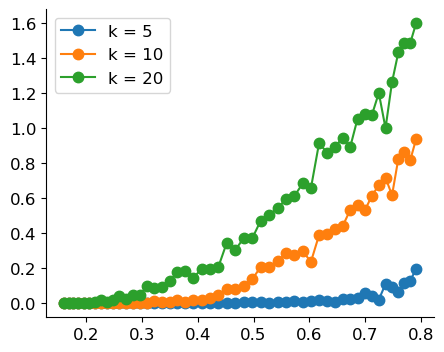

In [67]:
# plot results, approximately reproducing Figure 1 in the MS
# if you get a plot that qualitatively reproduces the main features of Figure 1,
# then that is good enough!
# It is very difficult to exactly match Newman's results (he used 100.000 nodes and 10.000 simulations per point)
fig,ax = plt.subplots(1, 1, figsize=(5, 4))

for kappa in results:
    T_s = [data['T'] for data in results[kappa]]
    S_s = np.array([data['Size'] for data in results[kappa]])
    ax.plot(T_s,S_s/1_000,
           label = 'k = ' + str(kappa),
           ls = '-',
           marker='.',
           ms = 15)
ax.legend()

### Exercise 5.15
Approximately find the critical transmissibility $T_c$ for different values of $\kappa$ in yourr simulations, and compare your results to those of the manuscript. Are they similar? Since we are simulating a smaller system, we do not expect a perfect match, but we do expect a similar qualitative behaviouor.

$k=5 T_c \approx 0.6$

$k=10 T_c \approx 0.4$

$k=20 T_c \approx 0.3$

### Exercise 5.16
Explain why $T_c$ decreases when $\kappa$ is increased. How is this related to the presence of super-spreaders, and how do they impact the global epidemic dynamics?

$k$ indicates the cutoff of the probability distribution of the degree of the network nodes.
Increasing k corresponds to increasing the contacts between people thus increasing the spread of the epidemic.

Each Infected has more contacts within the time he is contagious increasing the spread rate of the virus (with all other parameters unchanged)

The super-spreaders in our model are nodes with a high degree (namely a node with a high number of links).
The bigger k the higher is the probability of a super-spreader.
In a critical epidemic they can be the cause of the phase transition, by stocastically spread the disease to a very high number of nodes.